# Tracking the 2023 European Drought

Production date: 12-October-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Surface soil moisture anomalies (SSMA) for monitoring drought conditions and their temporal evolution across European regions.

## ❓ Quality assessment question(s)
**Is the C3S COMBINED satellite soil moisture dataset spatially and temporally complete enough to reliably calculate surface soil moisture anomalies and track drought evolution across Europe during 2023?**

Soil moisture data is critical for monitoring droughts. The Copernicus Climate Change Service (C3S) provides the COMBINED Surface Soil Moisture product (C3S-SM-COMBINED), which integrates active and passive microwave satellite observations to estimate surface soil moisture (2-5 cm depth) soil moisture and has a relatively low latency (ICDR updated on a 10-day cycle). The dataset has horizontal resolution of 0.25° x 0.25°. This quality assessment evaluates the usability of the dataset for tracking drought evolution across Europe from spring to mid-summer 2023 by calculating dekadal surface soil moisture anomalies (SSMA) during this period and analysing the completeness of observations across different European regions.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The C3S-SM-COMBINED dataset is not sufficiently complete to compute SSMA across Europe using a 30-year fully contiguous baseline, as data gaps are present. However, applying a 70% completeness threshold (equivalent to at least 21 valid years in the 1991–2020 baseline) allows for meaningful SSMA estimation. Under this threshold, the spatial and temporal patterns align well with documented soil moisture anomalies and drought conditions reported for spring–summer 2023. Nevertheless, the uncertainty introduced by the incomplete baseline must be acknowledged.
* The Iberian Peninsula and Central Europe show relatively high completeness (around 80%), with missing values primarily located in mountainous areas and regions with broadleaf vegetation. The severe drought conditions observed in the Iberian Peninsula during April and May 2023 are detected. In contrast, southern Italy and the Balkans exhibit lower completeness (around 50%), with gaps also concentrated in mountainous zones.
* In Great Britain and Ireland, completeness reaches only about 50%, with missing values clustered around large urban areas. This reduced data availability is likely associated with radio frequency interference (RFI) and complex urban land cover conditions.
* In the Nordic and Baltic regions, completeness varies seasonally, remaining very low in early spring but improving to over 50% during summer. Despite lower completeness levels in spring, the dataset captures the June drought conditions reported in the region.

```

## 📋 Methodology

The volumetric_surface_soil_moisture variable was downloaded from the C3S COMBINED satellite soil moisture dataset for the period 1991–2023, using the 10-day (dekadal) temporal aggregation. Data were spatially clipped to the European continent, and the long-term baseline (1991–2020) was used to compute dekadal means and standard deviations. Surface Soil Moisture Anomalies (SSMA) for 2023 were then calculated as standardized deviations from this baseline. A completeness threshold was applied, requiring that at least 70% of years in the baseline period contain valid data per pixel. Pixels below this threshold were excluded from the SSMA computation. This threshold was selected based on spatial completeness patterns observed in preliminary plots. Finally, regional analyses were performed for several European subregions, plotting the mean SSMA and data completeness over time to interpret drought evolution and assess data reliability across different climatic and geographic contexts.

**[](section-1)**
 * Download the COMBINED satellite soil moisture data from 1991 to 2023. Select the volumetric_surface_soil_moisture variable and choose the 10-day average as the time aggregation option.

**[](section-2)**
 * Extract soil moisture data in Europe.
 * Calculate the dekad mean and standard deviation for the long-term period 1991 to 2020.
 * Extract 2023 data into a separate set. 
 * Calculate and plot the SSMA for 2023 in relation to the long-term period data. Select the threshold for the percentage of minimum number years with data in the baseline from the observed completeness in the plots.

**[](section-3)**
 * Plot the mean SSMA and the completeness percentage over time for specific regions.
 * Analyse the results.
 

## 📈 Analysis and results

(section-1)=
### 1. Request and download data

#### Import packages

In [2]:
import xarray as xr
import numpy as np
import fsspec
import os
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from c3s_eqc_automatic_quality_control import download
from matplotlib import animation, pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import path
import matplotlib.dates as mdates
import rioxarray as rxr
import requests
import zipfile
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import calendar
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation, PillowWriter

plt.style.use("seaborn-v0_8-notebook")

#### Set the data request

In [3]:
collection_id = "satellite-soil-moisture"
request = {
    "variable": ["volumetric_surface_soil_moisture"],
    "type_of_sensor": ["combined_passive_and_active"],
    "time_aggregation": ["10_day_average"],
    "year": [
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": ["01", "11", "21"],
    "type_of_record": ["cdr"],
    "version": ["v202312"]
}


#### Download data

In [4]:
# Dataset
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_chunks=False,
)

shapefile_url = "https://figshare.com/ndownloader/files/23392280"

# Shapefile
with fsspec.open(f"simplecache::{shapefile_url}") as file:
    world_shape = geopandas.read_file(file)

100%|██████████| 33/33 [00:14<00:00,  2.29it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'pyogrio_ca33339703604879bf2e132f08800a31.zip': 'Continents' (default), 'Africa', 'North America', 'Europe', 'Oceania', 'South America', 'Asia', 'Antarctica', 'Australia'. Specify layer parameter to avoid this warning.
  result = read_func(


(section-2)=
### 2. Calculate SSMA

The SSMA was calculated following a similar approach as the one explained by the European Drought Observatory (EDO) [[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf). Surface soil moisture values for each pixel and each dekad from April to July 2023 were compared to the long-term climatological period (1991–2020, 30 years). The anomaly was computed using the following equation:

$\text{SMA} = \frac{\text{SMI}_t - \overline{\text{SMI}}}{\delta_{\text{SMI}}}$

where:

$\text{SMI}_t$ = Surface soil moisture 2023 for a specific dekad for that pixel

$\overline{\text{SMI}}$ = Mean surface soil moisture 1991-2020 for that same dekad for that pixel

$\delta_{\text{SMI}}$ = Standard deviation surface soil moisture 1991-2020 for that same dekad for that pixel

In [5]:
#Select soil mouisture variable
da=ds["sm"]
# Filter the shapefile to keep only Europe
europe_shape = world_shape[world_shape['CONTINENT'] == 'Europe']
# Ensure soil_moisture has CRS information compatible with europe_shape (e.g., EPSG:4326)
da.rio.write_crs("EPSG:4326", inplace=True)
# Clip soil moisture data to the Europe shape
da_eu = da.rio.clip(europe_shape.geometry, europe_shape.crs, drop=True)

In [6]:
# Select long-term (baseline) and target period
da_long_term = da_eu.sel(time=slice("1991-01-01", "2020-12-21"))
da_2023 = da_eu.sel(time=slice("2023-01-01", "2023-12-21"))

# Group baseline by day-of-year
doy_long_term = da_long_term.groupby("time.dayofyear")

# Count number of valid (non-NaN) years for each DOY at each pixel
valid_counts = doy_long_term.count(dim="time")

# Get total number of years expected (30 years here)
total_years = len(np.unique(da_long_term['time.year']))

# Define a completeness threshold
min_required_years = int(0.7 * total_years) #0.7 worked well, nothing is plotted with 0.8 or 0.9

# Create completeness mask: True = valid, False = incomplete
complete_mask = valid_counts >= min_required_years

# Compute long-term mean and std
mean_smi_long_term = doy_long_term.mean(dim="time")
std_smi_long_term = doy_long_term.std(dim="time")

# Replace zeros in std with NaN
std_smi_long_term_safe = std_smi_long_term.where(std_smi_long_term != 0)

# Group 2023 by DOY
doy_2023 = da_2023.groupby("time.dayofyear")
smi_2023 = doy_2023.mean(dim="time")

# Calculate SMA only where baseline is complete
sma_raw = (smi_2023 - mean_smi_long_term) / std_smi_long_term_safe
sma = sma_raw.where(complete_mask)  # Mask out incomplete baseline DOYs

# Remove inf values (e.g., divide by 0)
sma = sma.where(np.isfinite(sma))

#### Map of Europe SSMA

In [7]:
# Define custom colormap and boundaries
colors = [
    "#b35806ff",  # <-2
    "#f1a340ff",  # -2 to -1.5
    "#fee0b6ff",  # -1.5 to -1
    "#ffffffff",  # -1 to 1
    "#d1e5f0ff",  # 1 to 1.5
    "#67a9cfff",  # 1.5 to 2
    "#2166acff"   # >= 2
]
bounds = [-100, -2, -1.5, -1, 1, 1.5, 2, 100]  # Define boundaries

# Create colormap and norm
cmap = mcolors.ListedColormap(colors)
cmap.set_bad(color='lightgray')  # Gray for no data
norm = mcolors.BoundaryNorm(bounds, ncolors=len(colors), clip=True)

In [8]:
boxes = [
    {
        'label': 'Iberian Peninsula', 
        'min_lat': 35, 'max_lat': 44, 
        'min_lon': -10, 'max_lon': 5, 
        'color': 'red'
    },
    {
        'label': 'Great Britain and Ireland', 
        'min_lat': 50, 'max_lat': 60, 
        'min_lon': -11, 'max_lon': 2, 
        'color': 'orange'},

    {
        'label': 'Southern Balkans and Italy',
        'min_lat': 36, 'max_lat': 47,
        'min_lon': 7, 'max_lon': 24,
        'color': 'green'
    },
    {
        'label': 'Nordic and Baltic region',
        'min_lat': 55, 'max_lat': 71,
        'min_lon': 5, 'max_lon': 28,
        'color': 'blue'
    },

    {
        'label': 'Germany–Benelux–Poland',
        'min_lat': 48, 'max_lat': 54,
        'min_lon': 4, 'max_lon': 25,
        'color': 'purple'
    }
]


In [9]:
# Dekad DOYs and labels
dekad_days = [
    [91, 101, 111],    # April
    [121, 131, 141],   # May
    [152, 162, 172],   # June
    [182, 192, 202],   # July
    
]
month_labels = ['April', 'May', 'June', 'July']
dekad_labels = ['1st Dekad', '2nd Dekad', '3rd Dekad']

# Flatten DOYs and labels
all_doys = [doy for sublist in dekad_days for doy in sublist]
all_labels = [f"{month} - {dekad}" for month in month_labels for dekad in dekad_labels]

# === Create figure and axis ===
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=50)}, dpi=250)
ax.set_extent([-15, 35, 35, 72], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')


# === Add colored rectangles ===
def add_rectangles(ax):

    for box in boxes:
        width = box['max_lon'] - box['min_lon']
        height = box['max_lat'] - box['min_lat']
        rect = Rectangle(
            (box['min_lon'], box['min_lat']),
            width,
            height,
            linewidth=1,
            edgecolor=box['color'],
            facecolor='none',
            transform=ccrs.PlateCarree(),
            zorder=5
        )
        ax.add_patch(rect)

add_rectangles(ax)

# === Initial frame ===
sm_init = sma.sel(dayofyear=all_doys[0]).where(sma.sel(dayofyear=all_doys[0]) != 0, np.nan)
im = sm_init.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, norm=norm, add_colorbar=False  # <- disable auto colorbar
)
title = ax.set_title(f"Surface Soil Moisture Anomaly\n{all_labels[0]}", fontsize=10)

# Define bounds and ticks

ticks = bounds[1:-1]

# Add manual shared colorbar
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    fraction=0.03, pad=0.06, shrink=0.9,
    ticks=ticks, extend='both'
)
cbar.ax.tick_params(labelsize=8)          # Make tick numbers smaller
cbar.set_label('SSMA', fontsize=9)   


# === Animation update function ===
def update(frame_idx):
    doy = all_doys[frame_idx]
    label = all_labels[frame_idx]
    sm_doy = sma.sel(dayofyear=doy).where(sma.sel(dayofyear=doy) != 0, np.nan)
    im.set_array(sm_doy.values.flatten())  # Update the image data
    title.set_text(f"Surface Soil Moisture Anomaly\n{label}")
    return im,

# 4. Create animation
ani = FuncAnimation(fig, update, frames=len(all_doys), blit=False, interval=1000)
display(HTML(ani.to_jshtml()))
plt.close(fig)


*Figure 1. Surface soil moisture anomalies across Europe from spring to mid-summer 2023, based on the C3S-SM-COMBINED dataset. Anomalies are calculated relative to the 1991–2020 baseline period, considering only pixels with at least 70% data availability during the baseline period.*

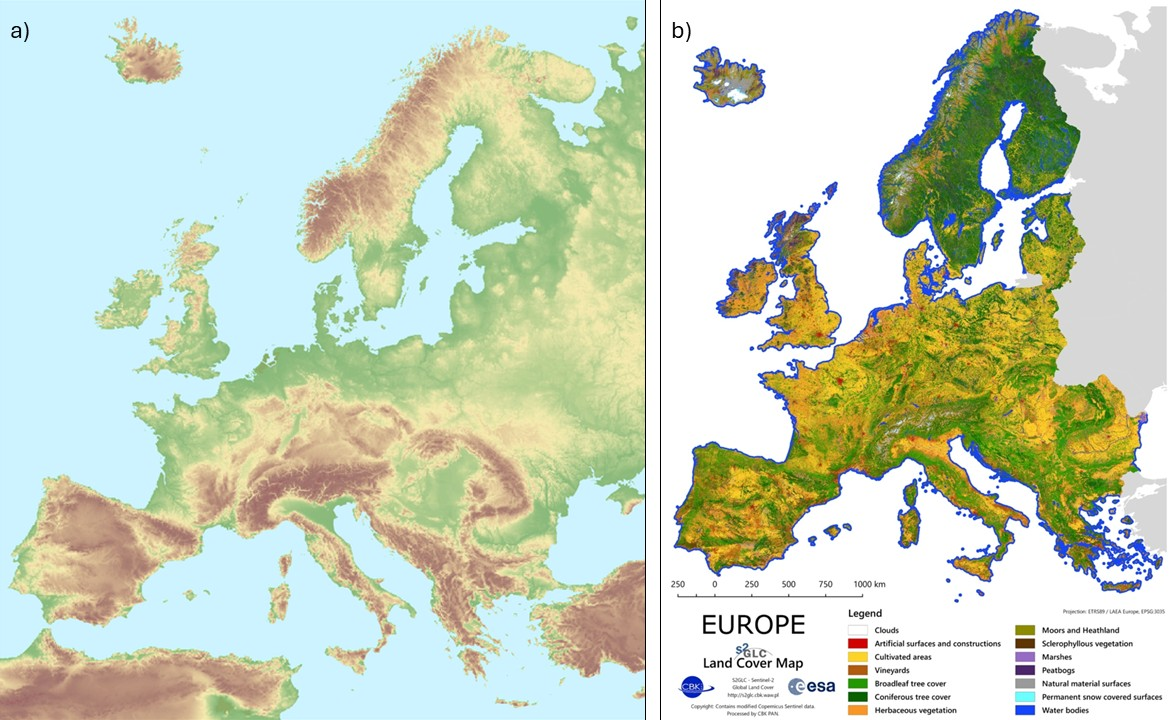

*Figure 2. a) Elevation map of Europe. Source: European Environment Agency, 2009 [[2]](https://www.eea.europa.eu/data-and-maps/figures/elevation-map-of-europe/europeelevation.eps/?searchterm=None) b) Land-cover maps of Europe. Source: European Space Agency, 2020 [[3]](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2/Land-cover_maps_of_Europe_from_the_Cloud)*

A threshold for the percentage of years with valid data in the baseline period was applied so that pixels with fewer valid years than the threshold were excluded from the SSMA computation. This ensures that anomalies are not calculated from an insufficiently representative baseline. Different thresholds were tested: a 0.9 threshold resulted in no valid pixels, and 0.8 yielded very few. Therefore, a threshold of 0.7 was selected, corresponding to at least 21 years of valid data available in the 1991–2020 baseline period. Although this does not meet the 30-year standard typically recommended for climatological analyses, it provides a reasonable basis for assessing soil moisture anomalies. However, it is important to acknowledge the increased uncertainty introduced by the incomplete baseline.

Areas of Europe with mountainous terrain and broadleaf tree cover at lower latitudes, as well as regions affected by seasonal soil moisture freeze–thaw processes and ice sheets at higher latitudes, tend to lack valid SSMA data in Figure 1. This pattern is consistent with the spatial and temporal completeness analysis presented in the Product Quality Assessment Report ([PQAR](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290728#SMv202312:ProductQualityAssessmentReport(PQAR)-Spatialandtemporalcompletenesss2.1)) for the dataset (see Figure 4 in the PQAR). The report notes that mountainous regions and areas affected by freeze–thaw processes exhibit lower data completeness. It also mentions that rainforest areas are permanently masked; although no such regions exist in Europe, areas with dense broadleaf vegetation tend to show reduced coverage, likely due to evapotranspiration and canopy effects that hinder soil moisture retrievals.

(section-3)=
### 3. Regional SSMA and completeness plots

The mean SSMA of the regions marked by boxes in Figure 1 were plotted over time. The completeness percentage in each box is plotted as well.

In [10]:
def plot_sma_mean_over_region(
    sma_data: xr.DataArray,
    box: dict,
    europe_shape,  # geopandas GeoDataFrame with European land
    start_doy=91,
    end_doy=202,
    year=2023,
    title=None
):
    """
    Plot average soil moisture anomaly (SSMA) and missing pixel percentage over a given region and period.
    """

    # --- Subset region ---
    sma_subset = sma_data.sel(
        longitude=slice(box['min_lon'], box['max_lon']),
        latitude=slice(box['max_lat'], box['min_lat'])
    )

    # --- Subset time ---
    available_doys = sma_subset.dayofyear.values
    target_doys = [doy for doy in available_doys if start_doy <= doy <= end_doy]
    if not target_doys:
        print(f"No matching DOYs in range {start_doy}–{end_doy}.")
        return
    sma_subset = sma_subset.sel(dayofyear=target_doys)

    # --- Land mask using Europe shapefile ---
    # Create a dummy grid with the same lat/lon as sma_subset
    dummy = xr.full_like(sma_subset.isel(dayofyear=0), fill_value=1)
    dummy = dummy.rio.write_crs("EPSG:4326")

    # Clip dummy with Europe geometry
    clipped = dummy.rio.clip(europe_shape.geometry, europe_shape.crs, drop=False)
    land_mask = clipped.notnull()  # True = land
    total_land_pixels = int(land_mask.sum().compute().item())
    if total_land_pixels == 0:
        print(f"No land pixels found in {box['label']}.")
        return

    # --- Mean SSMA ---
    sma_mean = sma_subset.mean(dim=["latitude", "longitude"], skipna=True)

    # --- Missing percentage per dekad ---
    valid_mask = sma_subset.notnull() & land_mask
    valid_count = valid_mask.sum(dim=["latitude", "longitude"])
    completeness_perc = (valid_count / total_land_pixels * 100).compute()

    # --- Dates ---
    date_index = pd.to_datetime(
        [f"{year}-{doy}" for doy in sma_subset.dayofyear.values],
        format="%Y-%j"
    )

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=250)
    color = box.get('color', 'blue')
    label = box.get('label', 'Region')

    ax1.plot(date_index, sma_mean, marker='o', linestyle='-', color=color, label='Mean SSMA')
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Mean SSMA", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1)

    # Right axis: % Completeness
    ax2 = ax1.twinx()
    ax2.plot(date_index, completeness_perc, color='gray', linestyle='--', marker='x', label='% Completeness')
    ax2.set_ylabel("% Completeness (land pixels only)", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    ax2.set_ylim(0, 100)

    tick_days = [1, 11, 21]
    tick_dates = pd.date_range(start=date_index[0], end=date_index[-1], freq='D')
    custom_ticks = [d for d in tick_dates if d.day in tick_days]
    ax1.set_xticks(custom_ticks)
    ax1.set_xticklabels([d.strftime('%b %d') for d in custom_ticks], rotation=45)

    if title is None:
        title = f"Average SSMA and Missing Data over {label}\n{date_index[0].strftime('%b %d')}–{date_index[-1].strftime('%b %d')}"
    plt.title(title)

    lines, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()


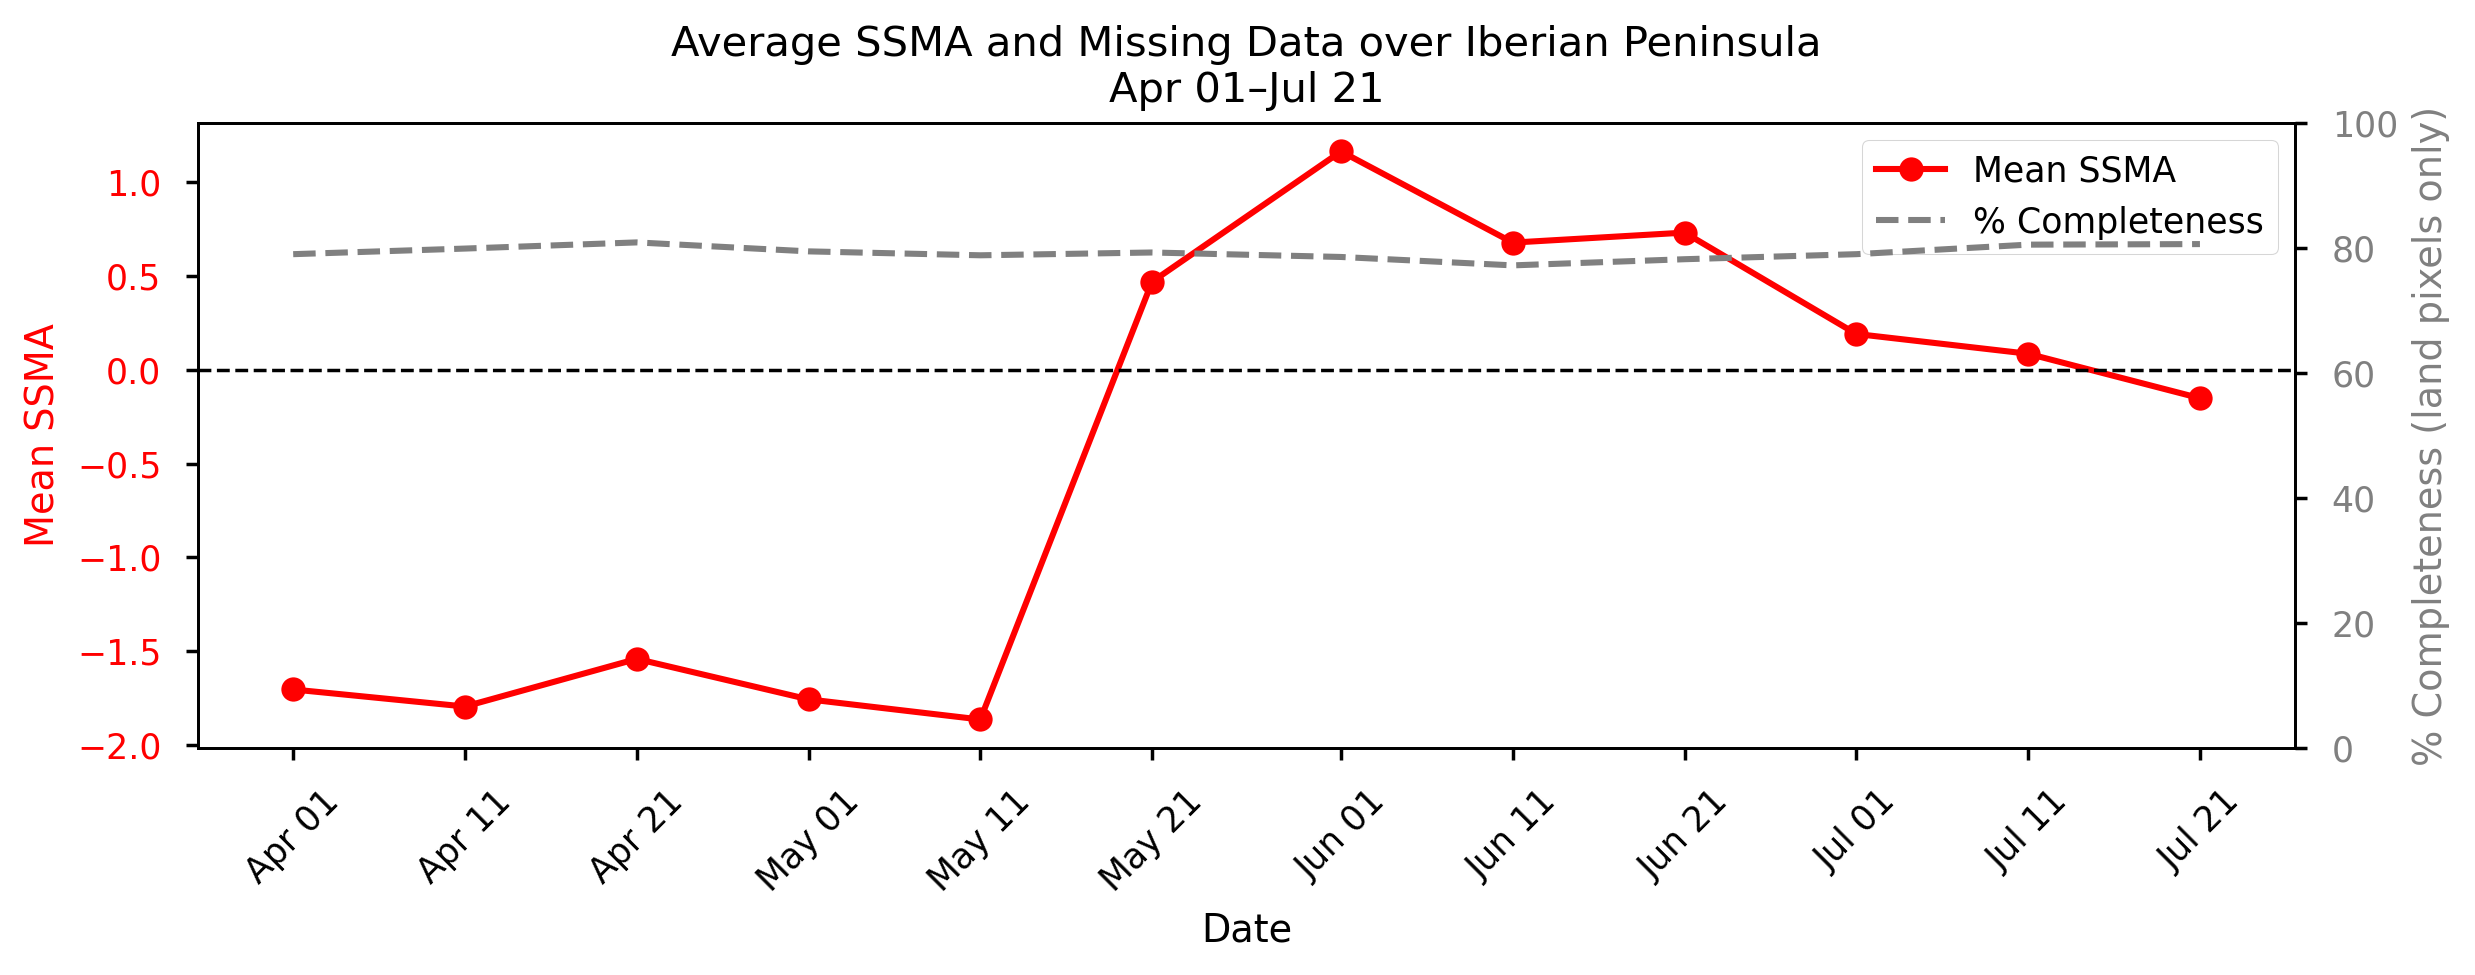

In [11]:
plot_sma_mean_over_region(sma, boxes[0], europe_shape, start_doy=91, end_doy=202, year=2023)

*Figure 3. Mean SSMA in the Iberian Peninsula from spring to mid-summer 2023 along with the corresponding percentage of data completeness.*

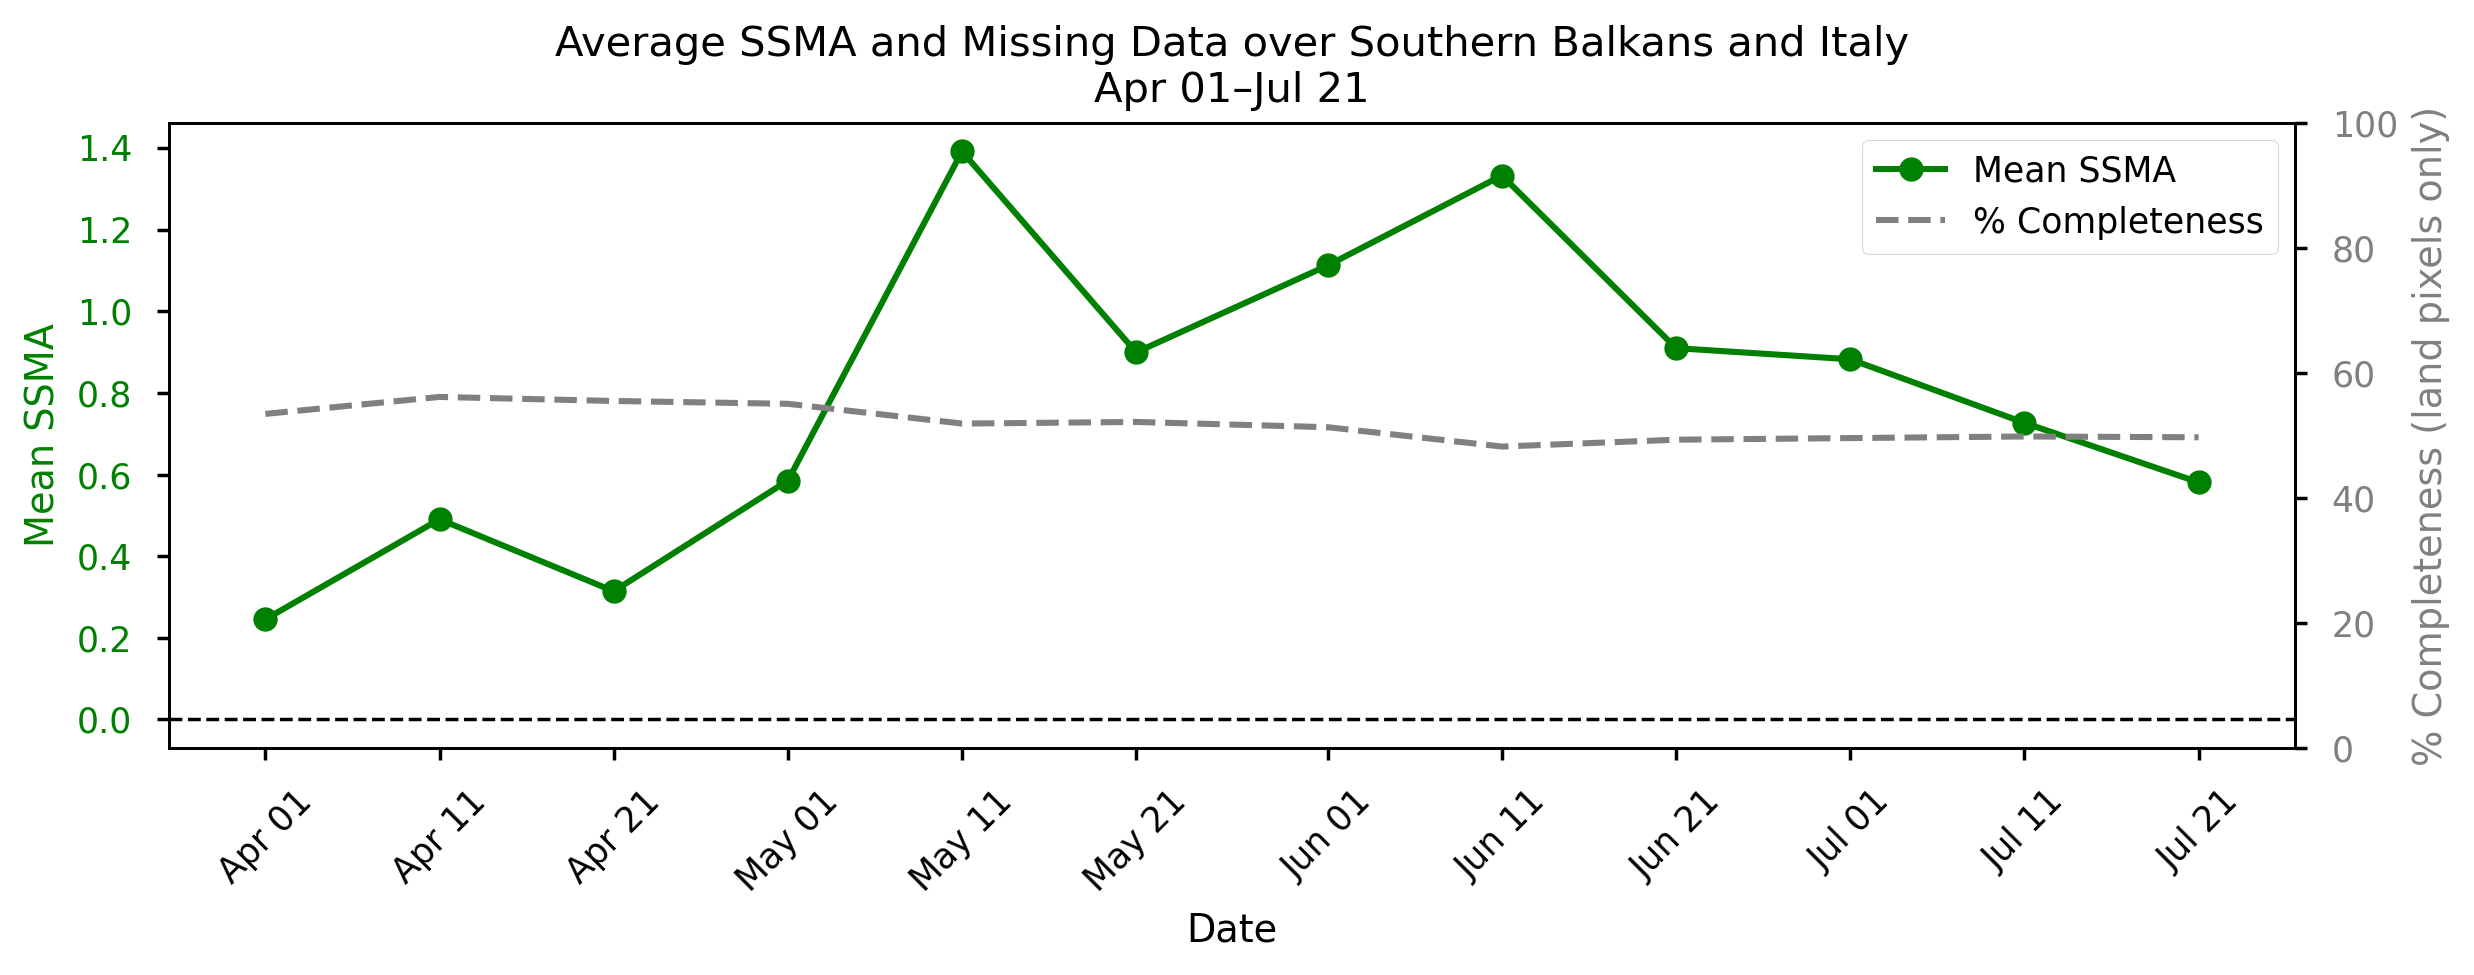

In [12]:
plot_sma_mean_over_region(sma, boxes[2], europe_shape, start_doy=91, end_doy=202, year=2023)

*Figure 4. Mean SSMA in the Southern Balkans and Italy from spring to mid-summer 2023 along with the corresponding percentage of data completeness.*

On top of low rainfall, a significant spring heatwave amplified drought conditions in the western Mediterranean in April 2023  [[4]](https://doi.org/10.1038/s41612-024-00569-6). According to the European Commission (2023) [[5]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en) the Combined Drought Indicator (CDI) showed warning and alert conditions across much of the western Mediterranean by mid-May, with drought conditions worse than those observed at the same time of the year in 2022. This situation is reflected in the SSMA results for the Iberian Peninsula (see Figure 3) The SSMA was notably negative, around -1.5 standard deviations, from April to mid-May. After late May, SSMA values increased, turning positive and gradually approaching normal conditions (near 0). 

Throughout the period from April to July 2023, approximately 80% of pixels in the Iberian Peninsula consistently met the 70% data availability threshold from the baseline period, allowing SSMA to be calculated (see Figure 3). Figures 1 and 2 show that the missing pixels are mainly concentrated along the northern coast of Spain, corresponding to the Cantabrian Mountains region, characterized by complex terrain and extensive broadleaf vegetation cover.

In contrast, crop-growing conditions improved in the Balkans, Italy, France, and Turkey during the same period [[5]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en). The European Commission also reported flooding in parts of Italy and the western Balkans in May 2023, caused by heavy precipitation [[6]](https://climate.copernicus.eu/precipitation-relative-humidity-and-soil-moisture-may-2023). This is consistent with observations in Figure 4, where the SSMA in southern Italy and the southern Balkans was positive, reaching 1.4 standard deviations by mid-May. However, these results are less meaningful, as these regions consistently exhibited a completeness of only around 50% over the period from April to July. In Figure 1, missing pixels are primarily concentrated in the Alps, while the Apennine Mountains show relatively few missing pixels.

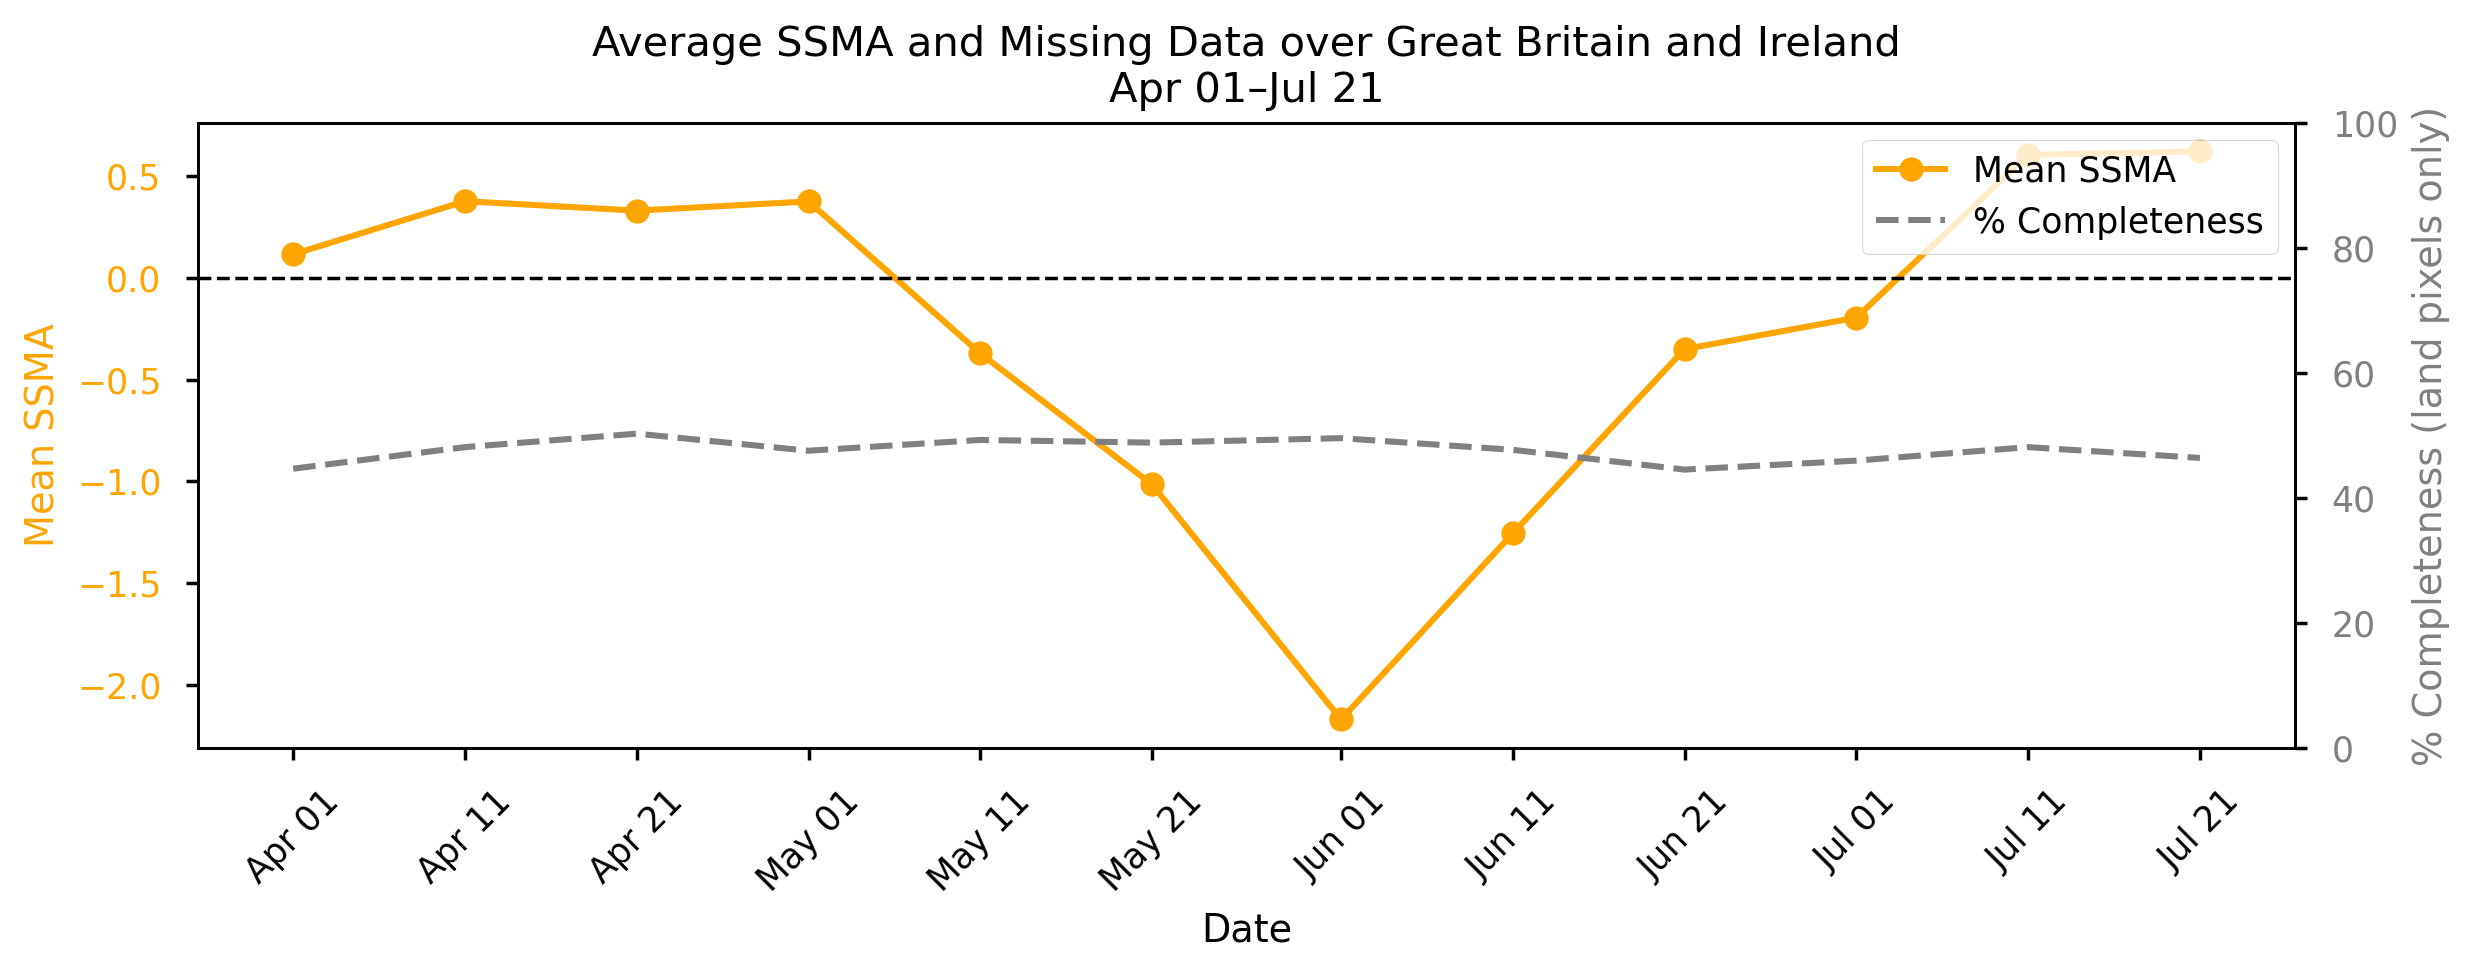

In [13]:
plot_sma_mean_over_region(sma, boxes[1], europe_shape, start_doy=91, end_doy=202, year=2023)

*Figure 5. Mean SSMA in Great Britain and Ireland from spring to mid-summer 2023 along with the corresponding percentage of data completeness.*

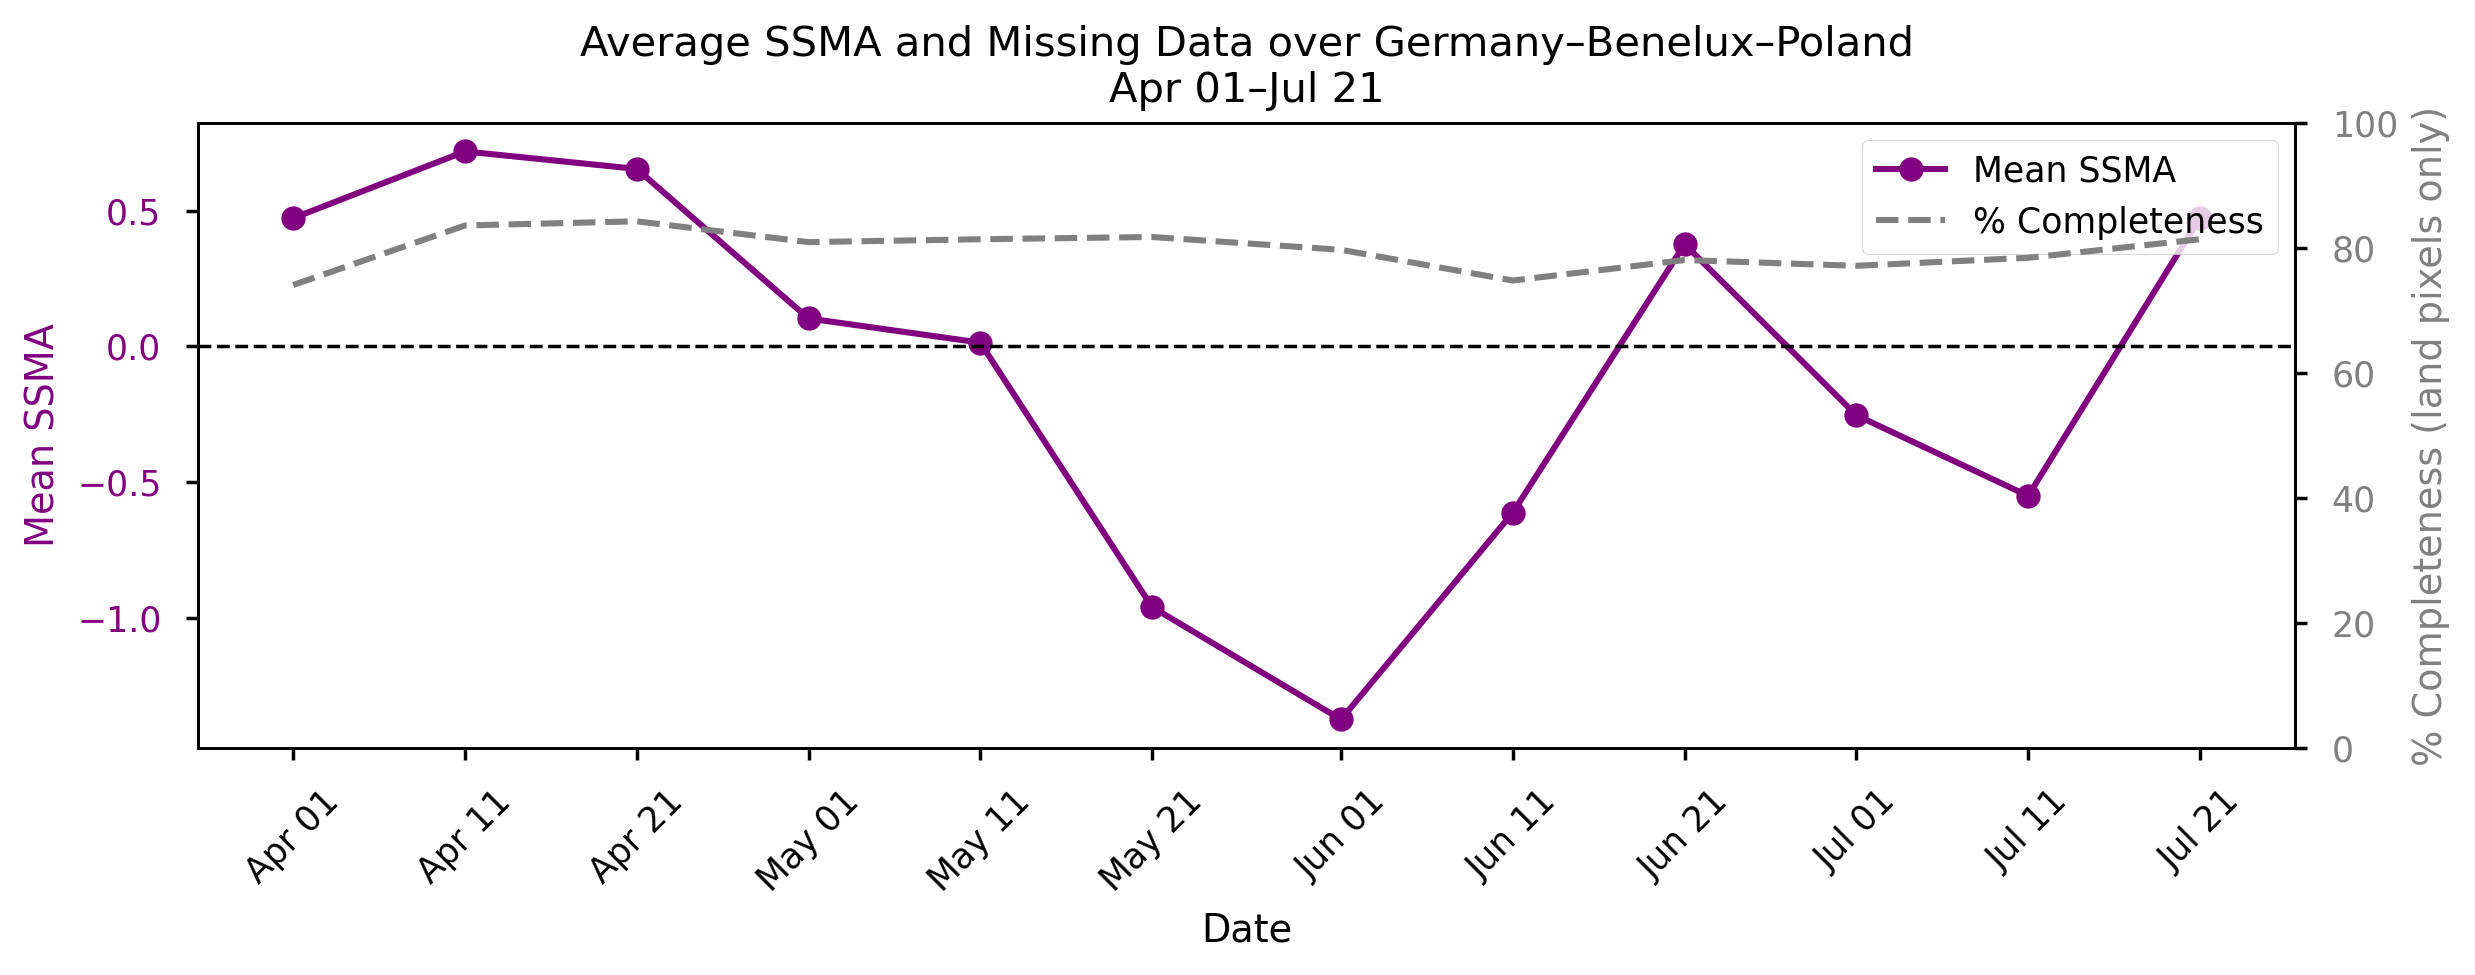

In [14]:
plot_sma_mean_over_region(sma, boxes[4], europe_shape, start_doy=91, end_doy=202, year=2023)

*Figure 6. Mean SSMA in Germany–Benelux–Poland from spring to mid-summer 2023 along with the corresponding percentage of data completeness.*

Great Britain, Ireland, and much of central Europe exhibited a notable negative SSMA peak at the beginning of June (see Figure 5 and Figure 6). This pattern aligns with reports that much of central and northern Europe experienced drier-than-normal conditions in June 2023 [[7]](https://doi.org/10.2760/575433).

Unlike the Iberian Peninsula, Italy, and the Southern Balkans, in Great Britain the missing pixels are not concentrated in the more mountainous or forested areas of the north. Instead, they are mainly found in the south, in and around large urban areas such as London, Birmingham, and Manchester. This pattern is likely related to radio frequency interference (RFI) and the influence of urban land cover on satellite observations. The completeness in this region remains consistently around 50% throughout the period.

In contrast, the Germany–Benelux–Poland region shows a higher completeness, around 80%. The missing pixels are mainly located in mountainous areas, such as the Ardennes in Belgium, and along the Dutch coastline, where the combination of dense urbanization, surface wetness, and mixed land–water pixels can reduce data quality.

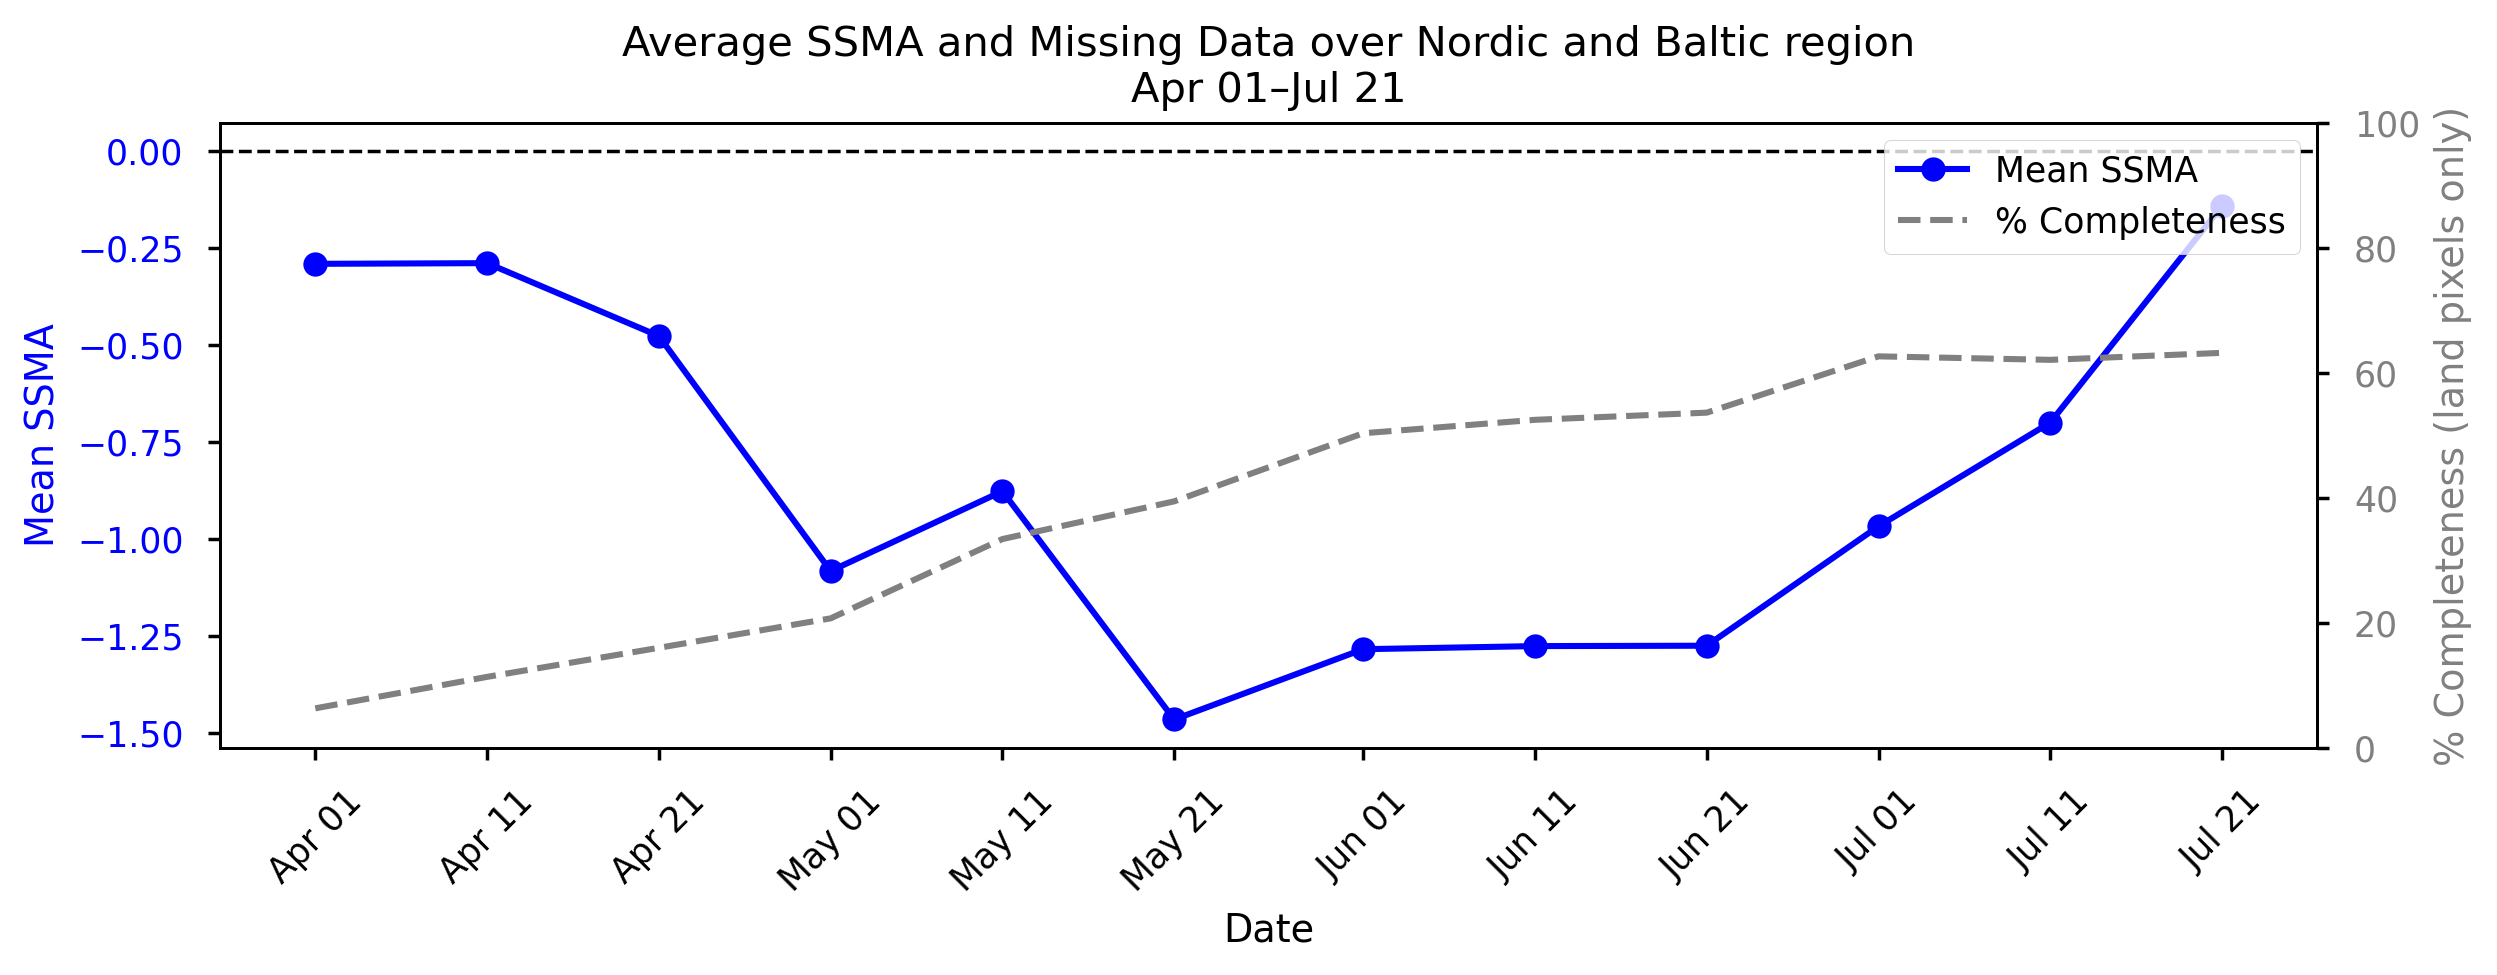

In [15]:
plot_sma_mean_over_region(sma, boxes[3], europe_shape, start_doy=91, end_doy=202, year=2023)

*Figure 7. Mean SSMA in the Nordic and Baltic region from spring to mid-summer 2023 along with the corresponding percentage of data completeness.*

The mean SSMA over the Nordic and Baltic region as shown in Figure 7 only starts being meaninful in June, when the completeness reaches more than 50%. This lack of data can be attributed to the presence of snow cover and frozen soil still during spring. According to [PUGS](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290955), the C3S Surface Soil Moisture v202312 product cannot retrieve meaningful data when the ground is snow-covered or frozen. Under such conditions, the dielectric properties of water change significantly, making satellite-based retrieval unreliable.

During June, the SSMA values in the region were negative, indicating dry conditions that gradually returned to normal in July. These drought conditions are consistent with reports from the same period — the Danish Emergency Management Agency issued warnings about an increased wildfire risk due to prolonged dry weather, while several Nordic and Baltic countries experienced below-average rainfall and rising temperatures, leading to forest fire alerts. Small wildfires were reported across parts of Norway, Sweden, Denmark, and Finland (NOAA, 2023) [[8]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/global-drought/202306). 

## ℹ️ If you want to know more

* Markonis, Y., Kumar, R., Hanel, M., Rakovec, O., Máca, P., & AghaKouchak, A. (2021). The rise of compound warm-season droughts in Europe. Science Advances, 7(6), eabb9668. [](https://doi.org/10.1126/sciadv.abb9668)
* Ministerio para la Transición Ecológica y el Reto Demográfico (2023). El 14,6% del territorio está en emergencia por escasez de agua y el 27,4%, en alerta. Nota de prensa. [](https://www.miteco.gob.es/es/prensa/ultimas-noticias/2023/09/el-14-6--del-territorio-esta-en-emergencia-por-escasez-de-agua-y.html)
* Laguardia, G. & Niemeyer, S. (2008). On the comparison between the LISFLOOD modelled and the ERS/SCAT derived soil moisture estimates. Hydrol. Earth Syst. Sci., 12, 1339–1351. [](https://hess.copernicus.org/articles/12/1339/2008/)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Dataset documentation:

* [SM v202212: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355349314)

* [SM v202312: Algorithm Theoretical Basis Document (ATBD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=453676750)

* [SM v202312: Product Quality Assurance Document (PQAD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290971)

* [SM v202312: Product Quality Assessment Report (PQAR)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=445290728#SMv202312:ProductQualityAssessmentReport(PQAR)-Spatialandtemporalcompletenesss2.1)

### References


[[1]](https://drought.emergency.copernicus.eu/data/factsheets/factsheet_soilmoisture.pdf) European Commission (2019). EDO INDICATOR FACTSHEET Soil Moisture Anomaly (SMA). European Drought Observatory.

[[2]](https://www.eea.europa.eu/data-and-maps/figures/elevation-map-of-europe/europeelevation.eps/?searchterm=None) European Environment Agency (2009).

[[3]](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2/Land-cover_maps_of_Europe_from_the_Cloud) European Space Agency (2020). 

[[4]](https://doi.org/10.1038/s41612-024-00569-6) Lemus-Canovas, M., Insua-Costa, D., Trigo, R. & Miralles, D. (2024). Record-shattering 2023 Spring heatwave in western Mediterranean amplified by long-term drought. npj Clim Atmos Sci 7, 25.

[[5]](https://joint-research-centre.ec.europa.eu/jrc-news-and-updates/severe-drought-western-mediterranean-faces-low-river-flows-and-crop-yields-earlier-ever-2023-06-13_en) European Commission (2023a). Severe drought: western Mediterranean faces low river flows and crop yields earlier than ever. European Drought Observatory. The Joint Research Centre: EU Science Hub.

[[6]](https://climate.copernicus.eu/precipitation-relative-humidity-and-soil-moisture-may-2023) European Commission (2023c). Precipitation, relative humidity and soil moisture for May 2023.

[[7]](https://doi.org/10.2760/575433) Toreti, A., Bavera, D., Acosta Navarro, J., Arias-Muñoz, C., Barbosa, P., De Jager, A., Di Ciollo, C., Fioravanti, G., Grimaldi, S., Hrast Essenfelder, A., Maetens, W., Magni, D., Masante, D., Mazzeschi, M., Mccormick, N. & Salamon, P. (2023). Drought in Europe June 2023. Publications Office of the European Union, Luxembourg, 2023, doi:10.2760/575433, JRC134492.

[[8]](https://www.ncei.noaa.gov/access/monitoring/monthly-report/global-drought/202306) NOAA National Centers for Environmental Information (2023). Monthly Climate Reports, Global Drought Narrative, June 2023.
